# From Augmented LLM to Autonomous Agent

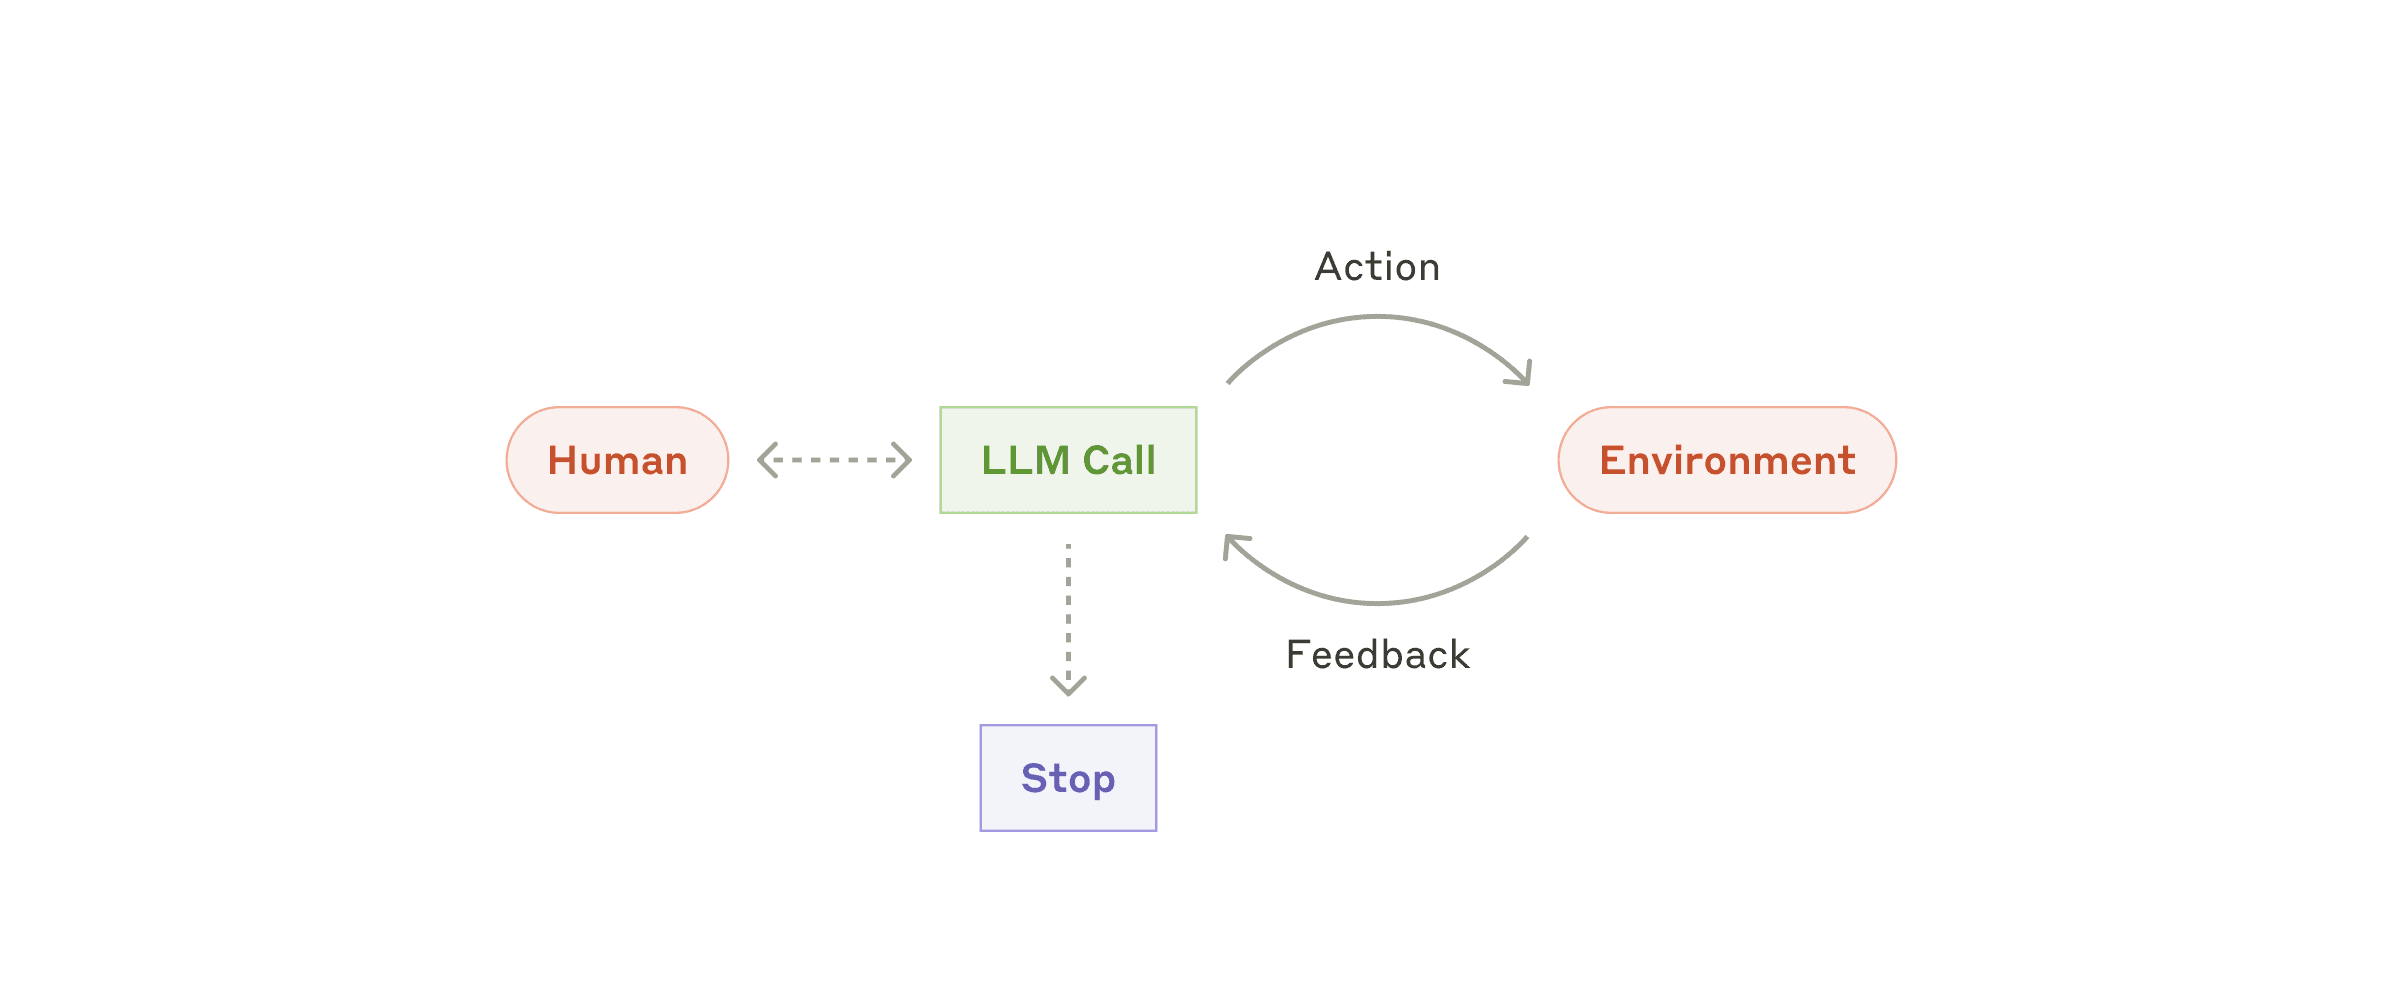

Autonomous agents can handle sophisticated tasks, but their implementation is often straightforward. They are typically just LLMs using tools based on environmental feedback in a loop. It is therefore crucial to design toolsets and their documentation clearly and thoughtfully. Agents can be used for open-ended problems where it’s difficult or impossible to predict the required number of steps, and where you can’t hardcode a fixed path. The LLM will potentially operate for many turns, and you must have some level of trust in its decision-making. Agents' autonomy makes them ideal for scaling tasks in trusted environments.

In [ ]:
%pip install boto3 sagemaker litellm -qU

Let's start by defining the tools that we will use throughout this example. We will use the OpenAI Completions format, and the tools variable will be a list of tuples, where the tuple has both the tool schema and the actual tool function.

In [ ]:
import json

def get_weather(city: str, country: str = "US") -> dict:
    """Get the current weather for a city."""
    # This is a mock implementation
    return {
        "city": city,
        "country": country,
        "temperature": 72,
        "conditions": "sunny"
    }
def translate_text(text: str, target_language: str) -> dict:
    """Translate text to the target language."""
    # This is a mock implementation
    return {
        "original": text,
        "translated": f"[{text} translated to {target_language}]",
        "target_language": target_language
    }

# Define the tools
tools = [
    # Weather tool
    ({
        "type": "function",
        "function": {
            "name": "get_weather",
            "description": "Get the current weather for a city",
            "parameters": {
                "type": "object",
                "properties": {
                    "city": {
                        "type": "string",
                        "description": "The name of the city"
                    },
                    "country": {
                        "type": "string",
                        "description": "The country code (default: US)",
                        "default": "US"
                    }
                },
                "required": ["city"]
            }
        }
    }, get_weather),
    # Translation tool
    ({
        "type": "function",
        "function": {
            "name": "translate_text",
            "description": "Translate text to another language",
            "parameters": {
                "type": "object",
                "properties": {
                    "text": {
                        "type": "string",
                        "description": "The text to translate"
                    },
                    "target_language": {
                        "type": "string",
                        "description": "The target language code (e.g., 'es' for Spanish)"
                    }
                },
                "required": ["text", "target_language"]
            }
        }
    }, translate_text)
]

Once the tools are defined, we can define the autonomous agent loop. For that, we will be create a class called `AutonomousAgent`.

## Amazon Bedrock + LiteLLM

In [ ]:
import json
import litellm

class AutonomousAgent:
    def __init__(self, model_id:str, tools:list=None, max_tokens:int=5*1024, temperature:float=0.1):
        self.model_id = model_id
        self.max_tokens = max_tokens
        self.temperature = temperature
        self.tools = tools
        self.messages = []
        print(f"Initialized AutonomousAgent with model {model_id}")

    def converse(self, input_text:str):
        self.messages = [{
            "role": "user", 
            "content": input_text
        }]
        print(f"New conversation started with input: {input_text[:100]}...")

        response = litellm.completion(
            messages=self.messages,
            model=self.model_id,
            max_tokens=self.max_tokens,
            temperature=self.temperature,
            tools=[x[0] for x in tools] if tools else None,
        )['choices'][0]['message']
        self.messages.append(dict(response))
        print("Received initial model response")

        # Loop until no more tool calls
        tool_call = True
        while tool_call is not None:
            tool_call = response.get('tool_calls', None)
            if tool_call:
                required_tool_name = tool_call[0].function.name
                required_tool_arguments = json.loads(tool_call[0].function.arguments)
                print(f"Tool call requested: {required_tool_name}")
                
                for tool_definition, tool_function in tools:
                    if tool_definition['function']['name'] == required_tool_name:
                        print(f"Executing tool {required_tool_name} with args: {required_tool_arguments}")
                        tool_response = tool_function(**required_tool_arguments)
                        break
                
                self.messages.append({
                    "tool_call_id": tool_call[0]['id'],
                    "role": "tool",
                    "name": required_tool_name,
                    "content": json.dumps(tool_response)
                })
                print(f"Tool {required_tool_name} execution completed")
                
                response = litellm.completion(
                    model=self.model_id,
                    messages=self.messages,
                    max_tokens=self.max_tokens,
                    temperature=self.temperature,
                    tools=[x[0] for x in tools] if tools else None,
                )['choices'][0]['message']
                self.messages.append(dict(response))
                print("Received follow-up model response")

                tool_call = response.get('tool_calls', None)
        return response.content


In [ ]:
agent = AutonomousAgent(model_id="bedrock/us.amazon.nova-pro-v1:0", tools=tools)
response = agent.converse("What is the weather in Bari, Italy?")
response

## Amazon SageMaker AI + LiteLLM

<div class="alert alert-block alert-info">
⚠️ As of LiteLLM v1.69.3, there is a bug in the <code>sagemaker_chat</code> provider implementation, therefore the code below will not work. We suggest implementing a SageMaker AI Autonomous Agent class which uses <code>boto3 invoke_endpoint()</code> API instead, like the one we provide below.
</div>

In [ ]:
endpoint_name = input("> Enter your endpoint name: ")
agent = AutonomousAgent(model_id=f"sagemaker_chat/{endpoint_name}", tools=tools)
# response = agent.converse("What is the weather in Bari, Italy?")
# response

## Amazon SageMaker AI (`boto3` SDK)

In [ ]:
import json
import boto3

class SageMakerAIAutonomousAgent:
    def __init__(self, endpoint_name:str, inference_component_name:str=None, tools:list=None, max_tokens:int=5*1024, temperature:float=0.1):
        self.endpoint_name = endpoint_name
        self.inference_component_name = inference_component_name
        self.max_tokens = max_tokens
        self.temperature = temperature
        self.tools = tools
        self.messages = []
        self.sagemaker_runtime = boto3.client('sagemaker-runtime')
        print(f"Initialized SageMakerAIAutonomousAgent with model {endpoint_name}")

    def invoke_endpoint(self, payload:dict) -> dict:
        if self.inference_component_name:
            response = self.sagemaker_runtime.invoke_endpoint(
                EndpointName=self.endpoint_name,
                InferenceComponentName=self.inference_component_name,
                ContentType='application/json',
                Body=json.dumps(payload)
            )
        else:
            response = self.sagemaker_runtime.invoke_endpoint(
                EndpointName=self.endpoint_name,
                ContentType='application/json',
                Body=json.dumps(payload)
            )
        return response
    
    def format_sagemaker_message(self, message: dict)->dict:
        # If content of the message is empty, replace with "Thinking ..."
        if message["content"] is None:
            message["content"] = "Thinking ..."
        # Drop anything which is not "role", "content"
        message = {k: v for k, v in message.items() if k in ["role", "content"]}
        return message

    def converse(self, input_text:str):
        self.messages = [{
            "role": "user", 
            "content": input_text
        }]
        print(f"New conversation started with input: {input_text[:100]}...")

        payload = {
            "messages": self.messages,
            "max_tokens": self.max_tokens,
            "temperature": self.temperature,
            "tools": [x[0] for x in tools] if tools else None
        }

        response = self.invoke_endpoint(payload)
        response = json.loads(response['Body'].read().decode())['choices'][0]['message']                
        self.messages.append(self.format_sagemaker_message(response))
        print("Received initial model response")

        # Loop until no more tool calls
        while True:
            tool_call = response.get('tool_calls', None)
            if tool_call:
                required_tool_name = tool_call[0]['function']['name']
                required_tool_arguments = json.loads(tool_call[0]['function']['arguments'])
                print(f"Tool call requested: {required_tool_name}")
                
                for tool_definition, tool_function in tools:
                    if tool_definition['function']['name'] == required_tool_name:
                        print(f"Executing tool {required_tool_name} with args: {required_tool_arguments}")
                        tool_response = tool_function(**required_tool_arguments)
                        break
                
                self.messages.append({
                    # "tool_call_id": tool_call[0]['id'],
                    "role": "user", 
                    # "name": required_tool_name,
                    "content": json.dumps(tool_response)
                })
                print(f"Tool {required_tool_name} execution completed")
                print(f"Messages: {self.messages}")
                payload = {
                    "messages": self.messages,
                    "max_tokens": self.max_tokens,
                    "temperature": self.temperature,
                    "tools": [x[0] for x in tools] if tools else None
                }
                
                response = self.invoke_endpoint(payload)
                response = json.loads(response['Body'].read().decode())['choices'][0]['message']
                self.messages.append(self.format_sagemaker_message(response))
                print("Received follow-up model response")

                tool_call = response.get('tool_calls', None)
            else:
                break
        return response["content"]


In [ ]:
agent = SageMakerAIAutonomousAgent(endpoint_name=endpoint_name, tools=tools)
agent.converse("What is the weather in Bari, Italy?")